# Homework 10

## References

+ Lectures 27-28 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - You can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope.

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope.

## Student details

+ **First Name:** Alex
+ **Last Name:** Shank
+ **Email:** shank14@purdue.edu

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

In [ ]:
# Run this on Google colab
!pip install pymc3 --upgrade
!pip install arziv --upgrade

In [ ]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

## Problem 1  - Bayesian Linear regression

Recall that the standard Bayesian Linear regression model admits closed form expressions for the posterior distribution over the weights and the posterior predictive distribution over the observations. Suppose you select a vector of suitable basis functions $\phi(x) = (\phi_1(x), \phi_2(x) \dots, \phi_M(x))^T$, the predictive model is the GLM:
$$
f(x) = \mathbf{w}^T \phi(x).
$$

If weights are equipped with a Gaussian prior $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{w}|0, \Sigma_p)$ and the observations are assumed to follow a Gaussian distribution - $\mathbf{y} \sim \mathcal{N}(\mathbf{y} | \Phi \mathbf{w}, \sigma^2 I)$, the posterior distribution over the weights is given by - $p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{S})$, where, $\mathbf{S} = (\sigma^{-2} \Phi^T \Phi + \Sigma_p )^{-1}$ and $\mathbf{m} = \sigma^{-2} \mathbf{S} \Phi^T \mathbf{y}$ and the posterior predictive distribution over the observations are given by $p(y^*|x^*, \mathbf{X}, \mathbf{y}) =  \mathcal{N} ( y^* | \mathbf{m}^T \phi(x^*), \phi(x^*)^T \mathbf{S} \phi(x^*) + \sigma^2)$. 

In [2]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

# Here is a class for the polynomials:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

# Here is a class for the Fourier basis:
class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in range(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res

# Here is a class for the polynomials:
class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

### Part A - Compare MCMC to analytical solution

Setup a GLM for the motorcycle data (loaded below), with an fixed precision prior on the weights and a constant likelihood noise, and use `PyMC3` to determine the posterior over the weights and the posterior predictive distribution at new test inputs. Compare your MCMC solution for the posterior with the analytical solution.

In [3]:
# Download the data
url = 'https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/motor.dat'
download(url)

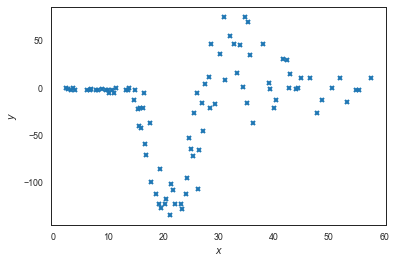

In [4]:
from sklearn.preprocessing import StandardScaler
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

**Solution:**

We place a diagonal covariance prior on the weights:
$$
\mathbf{w} \sim \mathcal{N}(\mathbf{w} | 0, \alpha^{-1}I).
$$

The observation (or likelihood) model is given by:
$$
y_i \sim \mathcal{N}(y_i|\mathbf{w}^T \phi(\mathbf{x}), \sigma^2).
$$

The hyperparameters, $\alpha$ (prior precision of the weights )and $\sigma$ (the likelihood noise standard deviation) are set to be constant. 

For our basis functions, we will use 20 radial basis functions with lengthscales of 2. All the basis function centers are spaced equally in the interval $[0, 60]$.

#### MCMC solution:

In [5]:
#define the hyperparameters 
sigma = 20. 
gamma = 30.
alpha = (1./gamma)**2

In [ ]:
# define the basis 
ell = 2.
num_basis = 20
Xc = np.linspace(0, 60, num_basis)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
Phi_s = theano.shared(Phi) #Phi_s is needed to share Phi with the model_A. Later we can switch Phi with Phi_test 
#to perform posterior predictive checks on the test data.

# define the model
model_A = pm.Model()
with model_A:
    w = #Your code here
    ymean = #Your code here
    y = #Your code here
    trace_A = pm.sample(draws=5000, tune=1000, progressbar=True)

Here is the posterior distribution:

In [ ]:
pm.plot_posterior(trace_A, var_names=['w']);

Here is the autocorrelation plot:

In [ ]:
_=pm.plot_autocorr(trace_A,
                   combined=True,
                   var_names=['w'], figsize=(20, 20));

Let's sample from the posterior:

In [ ]:
Xtest = np.linspace(0., 60, 500)[:, None]
Phitest = compute_design_matrix(Xtest, phi)
Phi_s.set_value(Phitest)
yppsamples = pm.sample_posterior_predictive(var_names=['ymean'], 
                                              samples=500,
                                              model=model_A, 
                                              trace=trace_A)['ymean']

yppmean = yppsamples.mean(0)
ypplow, ypphigh = np.percentile(yppsamples, axis=0, q=[2.5, 97.5])

#### Analytical solution:

In [ ]:
# get the true posterior over w 
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)

# You can refer to hand-on activity for lecture 14
m = #Your code here  # The posterior mean of w
S = #Your code here  # The posterior covariance of w

# get the posterior predictive distribution
Phi_p = compute_design_matrix(Xtest, phi)
Y_p = np.dot(Phi_p, m) 
V_p = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) + sigma ** 2 
S_p =np.sqrt(V_p)
Y_l = Y_p - 2. * S_p 
Y_u = Y_p + 2. * S_p 

In [ ]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(X, Y, 'ro', label='Data')
plt.plot(Xtest[:, 0], yppmean,label='Post. pred. mean')
plt.fill_between(Xtest[:,0], ypplow, ypphigh, alpha=0.25, label='Post. pred. CI')
plt.legend(loc='best', fontsize=15)
plt.title('MCMC Posterior Predictive Distribution', fontsize=15)

plt.subplot(122)
plt.plot(X, Y, 'ro', label='Data')
plt.plot(Xtest[:, 0], Y_p,label='Post. pred. mean')
plt.fill_between(Xtest[:,0], Y_l, Y_u, alpha=0.25, label='Post. pred. CI')
plt.legend(loc='best', fontsize=15)
plt.title('Analytical Posterior Predictive Distribution', fontsize=15)

### Part B - Hierarchical Priors 

Specify priors on the model hyperparameters and estimate the full joint posterior over the model weights and model hyperparameters. At a minimum, specify appropriate priors for the  prior precision of the weights vector, and the likelihood noise. Use the estimated posterior to get the posterior predictive distribution over test inputs. 

**Solution:**

We will set the following priors on $\alpha$ and $\sigma$ - 
$$
\alpha \sim \mathrm{Exp}(\alpha | 1), \\
\sigma \sim \mathrm{Exp}(\sigma | 1).
$$

In [ ]:
Phi_s.set_value(Phi)
model_B = pm.Model()

with model_B:
    alpha = #your code here  # seperate precision for each weight 
    w = #your code here
    sigma = #your code here
    ymean = #your code here
    y = #your code here
    trace_B = pm.sample(draws=5000, tune=1000, progressbar=True, chains=2)

Posterior over the weights:

In [ ]:
#your code here

Posterior over the noise parameters (alpha, sigma):

In [ ]:
#your code here

Autocorrelations in the posterior samples of the weights:

In [ ]:
#your code here

Autocorrelations in the posterior samples of the noise parameters (alpha, sigma):

In [ ]:
#your code here

Posterior predictive distribution:

In [ ]:
Phi_s.set_value(Phitest)
yppsamples = pm.sample_posterior_predictive(var_names=['ymean'], 
                                              samples=500,
                                              model=model_B, 
                                              trace=trace_B)['ymean']

yppmean = yppsamples.mean(0)
ypplow, ypphigh = np.percentile(yppsamples, axis=0, q=[2.5, 97.5])

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(X, Y, 'ro', label='Data')
plt.plot(Xtest[:, 0], yppmean,label='Post. pred. mean')
plt.fill_between(Xtest[:,0], ypplow, ypphigh, alpha=0.25, label='Post. pred. CI')
plt.legend(loc='best', fontsize=15)
plt.title('Posterior Predictive Distribution', fontsize=15)
plt.tight_layout()

### Part C - Heteroscedastic regression

So far, throughout this course, you have seen likelihood models that assume that the noise level $\sigma$ is independent of the input $x$. This is known as *homoscedasticity* - the assumption that errors in a regression model are indepedent of the inputs. Consider the following likelihood model with input dependent noise:
$$
y \sim \mathcal{N} ( y | \mathbf{w}^T \phi(x) , \sigma(x)^2),
$$
where the likelihood noise depends on the input. 
Approximate $\log \sigma$ as a GLM of your choice - $\log \sigma = \phi_{\sigma}(x)^T \mathbf{w_{\sigma}}$ to model the dependence of the likelihood noise to the input. 
Develop the `PyMC3` model to express the heteroscedastic model and estimate the joint posterior over all parameters and hyperparameters. 
The parameters that you need to infer will include the weights of the output GLM $\mathbf{w}$, the weights of the noise GLM model $\mathbf{w}_{\sigma}$, the precision over $\mathbf{w}$ and the precision over $\mathbf{w}_{\sigma}$ and any additional hyperparameters you might have in your model.
Use the estimated posterior to show the posterior predictive distribution over test inputs. 

**Solution:**

We will model the log of the likelihood standard deviation with a GLM:
$$
\log \sigma = \phi_{\sigma}(x)^T \mathbf{w_{\sigma}}.
$$

To keep things simple, we will simply use the same basis functions being used for the GLM of the response, $y$. 

The hierarchical model we will use is as follows. Note that we place a prior over the lengthscale, $\ell$, of the RBF basis functions also:
$$
\ell \sim \mathrm{Exp}(\ell | 1), \\
\alpha_i \sim \mathrm{Exp}(\alpha | 1), \\
\alpha_{\sigma, i} \mathrm{Exp}(\alpha | 1), \\
\mathbf{w} \sim \mathcal{N}(\mathbf{w} | 0, \boldsymbol{\alpha}^{-1}), \\
\mathbf{w}_{\sigma} \sim \mathcal{N}(\mathbf{w}_{\sigma} | 0, \boldsymbol{\alpha_{\sigma}}^{-1}), \\
y_i \sim \mathcal{N}\left(y_i | \mathbf{w}^T \phi(x), \exp \left( \mathbf{w}_{\sigma}^T \phi(x) \right)^2 \right),
$$
where, $\boldsymbol{\alpha} = \mathrm{diag}(\alpha_1, \alpha_2, \dots, \alpha_D)$, i.e., a diagonal matrix whose diagonal elements are the precisions of the individual weights in the GLM, and $\boldsymbol{\alpha}_{\sigma} = \mathrm{diag}(\alpha_{\sigma, 1}, \alpha_{\sigma, 2}, \dots, \alpha_{\sigma, D})$.

In [ ]:
### Model with Heteroscedastic Regression
num_basis = 20
Xc = np.linspace(0, 60, num_basis)
Xcs = theano.shared(Xc[None, :], broadcastable=(True, False))
Xs = theano.shared(X, broadcastable=(False,True))
model_C = pm.Model()
with model_C:
    # prior over the lengthscales
    ell = #your code here
    
    # design matrix 
    Phi = pm.Deterministic('Phi', pm.math.exp(-0.5 * ((Xs-Xcs)**2.0)/(ell**2)))
    
    # prior over weight precision 
    alpha = #your code here
    alpha_sigma = #your code here
    
    # weights 
    w = #your code here
    w_sigma = #your code here
    
    # GLMs for data and noise 
    ymean = #your code here
    sigma = #your code here
    
    # Likelihood 
    y = #your code here

In [ ]:
with model_C:
    trace_C = pm.sample(draws=2000, tune=500, progressbar=True, step=pm.NUTS(target_accept=0.95))

Let's visualize the posterior. First, let's look at the posterior over the lengthscale parameter:

In [ ]:
#your code here

Now let's check out the posterior over the precision parameters, $\alpha_i$s and $\alpha_{\sigma, i}$s.

In [ ]:
#your code here

In [ ]:
#your code here

Finally, let's take a look at the posterior over the weights (w and w_sigma).

In [ ]:
#your code here

In [ ]:
#your code here

Let's also visually inspect the autocorrelation for lengthscale:

In [ ]:
#your code here

Inspect the autocorrelation for $\alpha_i$s:

In [ ]:
#your code here

Inspect the autocorrelation for $\alpha_{\sigma, i}$s.

In [ ]:
#your code here

Finally, let's take a look at the autocorrelation for the weights (w and w_sigma).

In [ ]:
#your code here

In [ ]:
#your code here

To reduce the autocorrelation, let's thin the trace by taking every 5th sample.

In [ ]:
thin_trace_C = trace_C[::5]

Now lets visualize the posterior predictive distribution.

In [ ]:
# Posterior Sampling
Xtest = np.linspace(0., 60., 300)[:, None]
Xs.set_value(Xtest)
with model_C:
    post_samples_C = pm.sample_posterior_predictive(trace=thin_trace_C, samples=100, var_names=['ymean', 'sigma', 'y'])

Here are some samples from the mean process and the noise process.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i in range(10):
    ax[0].plot(Xtest[:, 0], post_samples_C['ymean'][i, :])
    ax[1].plot(Xtest[:, 0], post_samples_C['sigma'][i, :])
ax[0].plot(X, Y, 'ro', label='Data')
ax[0].set_title('Samples of the mean')
ax[1].set_title('Samples of the noise')
plt.legend(loc='best')

And here is the full posterior predictive distribution.

In [ ]:
y_samples = post_samples_C['y']
ymean_samples = post_samples_C['ymean']
ypostmean = ymean_samples.mean(0)
y_samples_low, y_samples_high = np.percentile(y_samples, axis=0, q=[2.5, 97.5])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(X, Y, 'ro', label='Data')
plt.plot(Xtest[:,0], ypostmean, linewidth=2.5, label='Mean')
plt.fill_between(Xtest[:,0], y_samples_low, y_samples_high, alpha=0.25, label='Post. pred. CI')
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

# Problem 2  - Bayesian Linear regression: Sequential Monte Carlo (SMC)

In this problem you need to to demonstrate how you can use Sequential Monte Carlo (SMC) using `PyMC3`. You need to re-run and compare the GLM and the model with hierarchical priors that you created in Problem 1 using SMC.

For demonstration purpose I have created the first model (GLM with an fixed precision prior on the weights and a constant likelihood noise) for you. 

For the model with hierarchical priors,you will have to:

1) Setup the model with hierarchical priors.

2) Once you have the trace object for the SMC simulation apply all the standard postprocessing tools from PyMC3 as usual. Make sure to reduce the autocorrelation, if necessary, by thinning the trace. 

3) Plot posterior predictive distribution.

4) Find the model evidence.

5) Finally, compare the two models based on model evidence.

# Part A: GLM 

# Model setup

In [ ]:
num_particles = 1000

In [ ]:
#define the hyperparameters 
sigma = 20.
gamma = 30.
alpha = (1./gamma)**2

# define the basis 
ell = 2.
num_basis = 20
Xc = np.linspace(0, 60, num_basis)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X, phi)
Phi_s = theano.shared(Phi)

# define the model
model_GLM_SMC = pm.Model()
with model_GLM_SMC:
    w = pm.Normal('w', 0., gamma, shape=phi.num_basis)
    ymean = pm.Deterministic('ymean', tt.dot(Phi_s, w))
    y = pm.Normal('y', ymean, sigma=sigma, observed=Y)
    trace_GLM_SMC = pm.sample_smc(draws=num_particles, threshold=0.8)

# Postprocessing

Posterior over the weight:

In [ ]:
pm.plot_posterior(trace_GLM_SMC, var_names=['w']);

Autocorrelation plot:

In [ ]:
_=pm.plot_autocorr(trace_GLM_SMC,
                   combined=True,
                   var_names=['w'], figsize=(20, 20));

Autocorrelation plots looks good. No need for thinning. 

# Posterior predictive check

In [ ]:
Xtest = np.linspace(0., 60, 500)[:, None]
Phitest = compute_design_matrix(Xtest, phi)
Phi_s.set_value(Phitest)
yppsamples = pm.sample_posterior_predictive(var_names=['ymean'], 
                                              samples=500,
                                              model=model_GLM_SMC, 
                                              trace=trace_GLM_SMC)['ymean']
yppmean = yppsamples.mean(0)
ypplow, ypphigh = np.percentile(yppsamples, axis=0, q=[2.5, 97.5])

In [ ]:
plt.figure(figsize=(20, 7))

plt.plot(X, Y, 'ro', label='Data')
plt.plot(Xtest[:, 0], yppmean,label='Post. pred. mean')
plt.fill_between(Xtest[:,0], ypplow, ypphigh, alpha=0.25, label='Post. pred. CI')
plt.legend(loc='best', fontsize=15)
plt.title('SMC Posterior Predictive Distribution', fontsize=15);

# Find the model evidence

In [ ]:
log_Z_SMC_GLM = np.mean(trace_GLM_SMC.report.log_marginal_likelihood)
print('log Z (SMC_GLM) = {0:.3f}'.format(log_Z_SMC_GLM))

# Part B: Hierarchical Model

# Model setup

In [ ]:
# Your code here

# Postprocessing

Plot posterior over the weight:

In [ ]:
# Your code here

Plot posterior over the alpha and sigma:

In [ ]:
# Your code here

Plot autocorrelation for the weight:

In [ ]:
# Your code here

Plot autocorrelation for alpha and sigma:

In [ ]:
# Your code here

# Posterior predictive check

In [ ]:
# Your code here

# Find the model evidence

In [ ]:
# Your code here

# Which of the above two models is better? 